# CRAFTY

## Dataset

Importiamo i dataset con `pandas` cercando di risparmiare memoria andando a specificare, tramite
il parametro `dtype` il tipo e la dimensione dei dati di ogni colonna.

In questo modo risparmiamo quasi 1 GB di RAM e velocizziamo il caricamento del dataset.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import bs4
import requests
import time

tx_df = pd.read_csv(
    "transactions.csv",
    names=["timestamp", "blk", "tx", "is_coinbase", "fee"],
    dtype={
        "timestamp": np.uint32,
        "blk": np.uint32,
        "tx": np.uint32,
        "is_coinbase": np.uint8,
        "fee": np.uint64,
    },
)
tx_df["timestamp"] = pd.to_datetime(tx_df["timestamp"], unit="s")

## Analisi

In questa prima fase andiamo ad effettuare delle analisi generali sul dataset.

### Distribuzione del numero di transazioni per blocco

Vogliamo ricavare la **distribuzione** del numero di transazioni per blocco, nell'intero periodo
temporale considerato.

Per prima cosa raggruppiamo il dataset per blocchi e per transazioni.


In [2]:
blk_grp = tx_df.groupby("blk")

Dato che ogni riga del dataset rappresenta una transazione e dato che ogni transazione ha un
identificatore univoco, questa comparirà al più una volta nel dataset.

Siamo quindi in grado di ottenere il numero di transazioni per blocco tramite la funzione di
aggregazione `count`.


In [3]:
tx_per_blk = blk_grp["tx"].count()

#### Plot

Non ci rimane che plottare un grafico che rappresenti la distribuzione ottenuta.


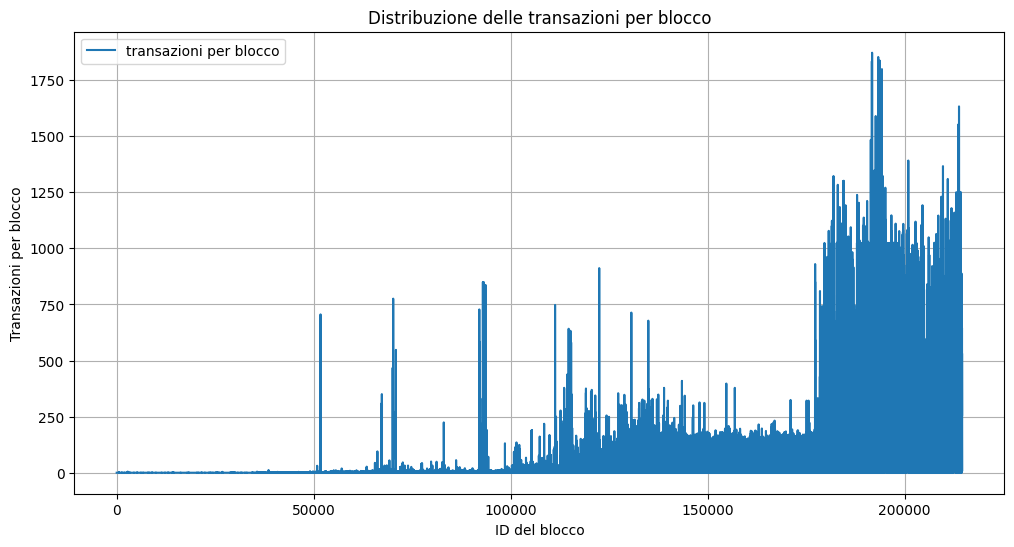

In [4]:
x = tx_per_blk.index.to_list()
y = tx_per_blk.values.tolist()

plt.figure(figsize=(12, 6))
plt.plot(x, y, label="transazioni per blocco")

plt.title("Distribuzione delle transazioni per blocco")
plt.xlabel("ID del blocco")
plt.ylabel("Transazioni per blocco")
plt.legend()
plt.grid()
plt.show()

### Occupazione dei blocchi nel tempo

La seconda analisi prevede lo studio dell'evoluzione dell'occupazione dei blocchi nel tempo.

In particolare dobbiamo andare a considerare intervalli di due mesi.


In [5]:
timestamps = blk_grp["timestamp"].min().to_frame()

# transazioni per blocco con timestamp
tx_per_blk_ts = pd.concat([tx_per_blk, timestamps], axis="columns")
tx_per_blk_ts = tx_per_blk_ts.rename(columns={"tx": "tx_count"})
two_month_mean_blk_size = tx_per_blk_ts.groupby(
    pd.Grouper(key="timestamp", freq="2MS")
)["tx_count"].mean()

#### Plot

A questo punto possiamo plottare il grafico dell'evoluzione dell'occupazione dei blocchi ogni due
mesi.


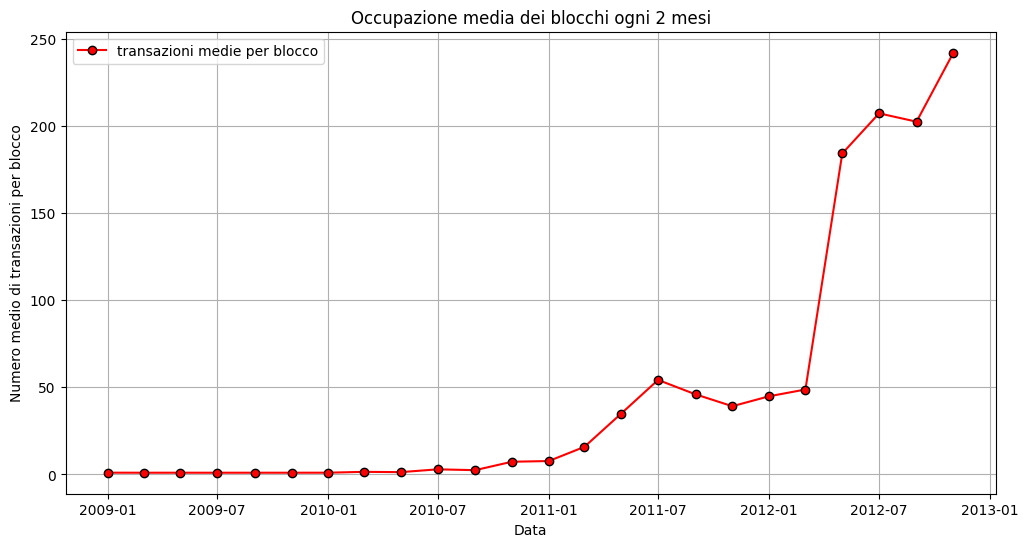

In [6]:
x = two_month_mean_blk_size.index.to_list()
y = two_month_mean_blk_size.values.tolist()

plt.figure(figsize=(12, 6))
plt.plot(x, y, c="r", marker="o", mec="k", label="transazioni medie per blocco")

plt.title("Occupazione media dei blocchi ogni 2 mesi")
plt.xlabel("Data")
plt.ylabel("Numero medio di transazioni per blocco")
plt.grid()
plt.legend()
plt.show()

### Totale UTXO

Passiamo ora a calcolare l'ammontare totale degli **UTXO** al momento dell'ultima transazione
registrata nel dataset.

L'idea è quella di calcolare prima tutto l'output che è stato speso e poi sottrarlo dall'output
totale prodotto.

Per arrivare a questo risultato effettuiamo un'operazione di `merge` tra il dataset degli **input**
e il dataset degli **output** usando come valori su cui basare l'operazione gli identificatori
delle transazioni in input e output e gli indici di posizione degli output.

In questo modo otterremo un dataset in cui saranno presenti solo le transazioni riferite come input
da altre transazioni.


In [7]:
in_df = pd.read_csv(
    "inputs.csv",
    names=["tx", "utxo_tx", "utxo_out_pos"],
    dtype={"tx": np.uint32, "utxo_tx": np.uint32, "out_pos": np.uint16},
)

out_df = pd.read_csv(
    "outputs.csv",
    names=["tx", "out_pos", "address", "amount", "script_type"],
    dtype={
        "tx": np.uint32,
        "out_pos": np.uint16,
        "address": np.uint32,
        "amount": np.uint64,
        "script_type": np.uint8,
    },
)

spent_df = in_df.merge(
    out_df, how="inner", left_on=["utxo_tx", "utxo_out_pos"], right_on=["tx", "out_pos"]
).rename(columns={"tx_x": "tx", "tx_y": "in_tx"})

A questo punto possiamo sommare i valori della colonna `amount` del dataset ottenuto per
ricavare l'output speso.

Se invece sommiamo i valori della colonna `amount` del dataset degli **output** ricaviamo il valore
totale degli output sia speso che non speso.

Se ora effettuiamo la differenza tra il il valore totale degli output e il valore totale degli
output spesi ricaviamo l'**UTXO** totale.


In [8]:
utxo = out_df["amount"].sum() - spent_df["amount"].sum()
print(f"UTXO totale: {utxo}")

UTXO totale: 859303372614879


#### Plot

Tramite un grafico a torta è possibile comparare l'output speso con l'**UTXO**.


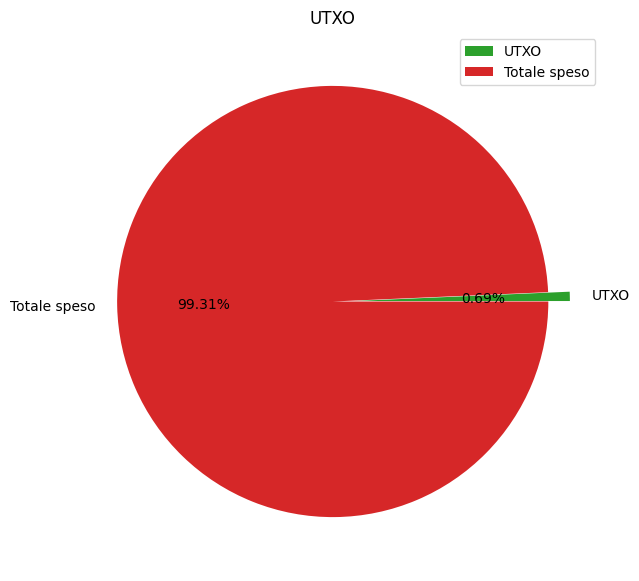

In [9]:
plt.figure(figsize=(10, 7))
plt.pie(
    [utxo, spent_df["amount"].sum()],
    explode=(0.1, 0),
    labels=["UTXO", "Totale speso"],
    colors=["tab:green", "tab:red"],
    autopct="%.2f%%",
)

plt.title("UTXO")
plt.legend()
plt.show()

### Distribuzione intervalli di tempo

Siamo ora interessati a capire come è fatta la distribuzione degli intervalli di tempo che
intercorrono tra la transazione che genera un valore in output e quella che lo consuma.

Abbiamo già a disposizione un dataframe che mette in correlazione gli input e gli output.

Dobbiamo solo aggiungere il campo timestamp per entrambe le transazioni.


In [10]:
spent_time_df = (
    spent_df.merge(tx_df, how="inner", on="tx")
    .drop(columns=["blk", "tx", "is_coinbase", "fee"])
    .rename(columns={"timestamp": "spent_time"})
)

spent_time_df = (
    spent_time_df.merge(tx_df, how="inner", left_on="in_tx", right_on="tx")
    .drop(columns=["blk", "tx", "is_coinbase", "fee"])
    .rename(columns={"timestamp": "gen_time"})
)

days = (spent_time_df["spent_time"] - spent_time_df["gen_time"]).dt.days

#### Plot

A questo punto abbiamo un vettore contenente il numero di giorni di vita di ogni transazione.

Sull'asse $x$ abbiamo la lunghezza degli intervalli di tempo (in giorni) prima che un output
venisse speso.

Sull'asse $y$ abbiamo invece la quantità di output che vengono spesi ogni $x$ giorni.


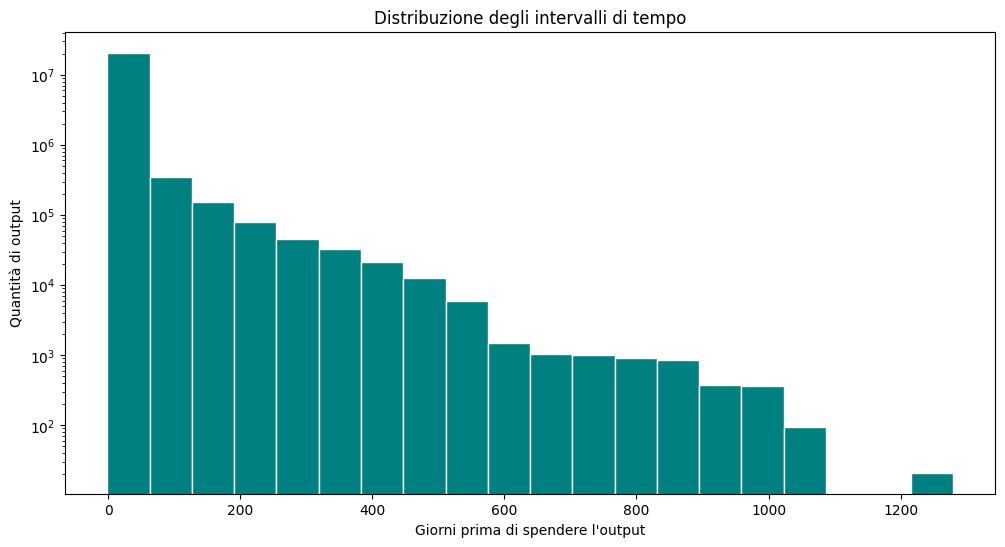

In [11]:
plt.figure(figsize=(12, 6))
plt.hist(days, bins=20, ec="w", color="teal")

plt.title("Distribuzione degli intervalli di tempo")
plt.xlabel("Giorni prima di spendere l'output")
plt.ylabel("Quantità di output")
plt.yscale("log")

### Distribuzione delle fee

In quest'ultima fase vogliamo fare due analisi

1. Ricavare la distribuzione del numero di _fee_ e il valor medio di _fee_ al mese.
2. Mettere a confronto la distribuzione di _fee_ nulle e la distribuzione di _fee_ non nulle nel
   tempo.

Per prima cosa raggruppiamo il dataset per mese e ricaviamo il numero di _fee_ e il valor medio di
mensile.


In [12]:
ts_grp = tx_df.groupby(pd.Grouper(key="timestamp", freq="1MS"))
fee_per_month = ts_grp["fee"].count()
fee_value_per_month = ts_grp["fee"].mean()

Vogliamo ora dividere il dataset in due parti:

- Transazioni con _fee_ nulle.
- Transazioni con _fee_ non nulle.

Una volta separati andiamo a raggruppare nuovamente per mese e calcoliamo, per entrambi i dataset
ricavati, il numero di _fee_ mensile.


In [13]:
zero_fee = tx_df[tx_df["fee"] == 0]
non_zero_fee = tx_df[tx_df["fee"] > 0]

zero_fee_grp = zero_fee.groupby(pd.Grouper(key="timestamp", freq="1MS"))
zero_fee_count = zero_fee_grp["fee"].count()

non_zero_fee_grp = non_zero_fee.groupby(pd.Grouper(key="timestamp", freq="1MS"))
non_zero_fee_count = non_zero_fee_grp["fee"].count()

#### Plot

Dato che abbiamo calcolato due distribuzioni ho optato per effettuare un doppio plot.


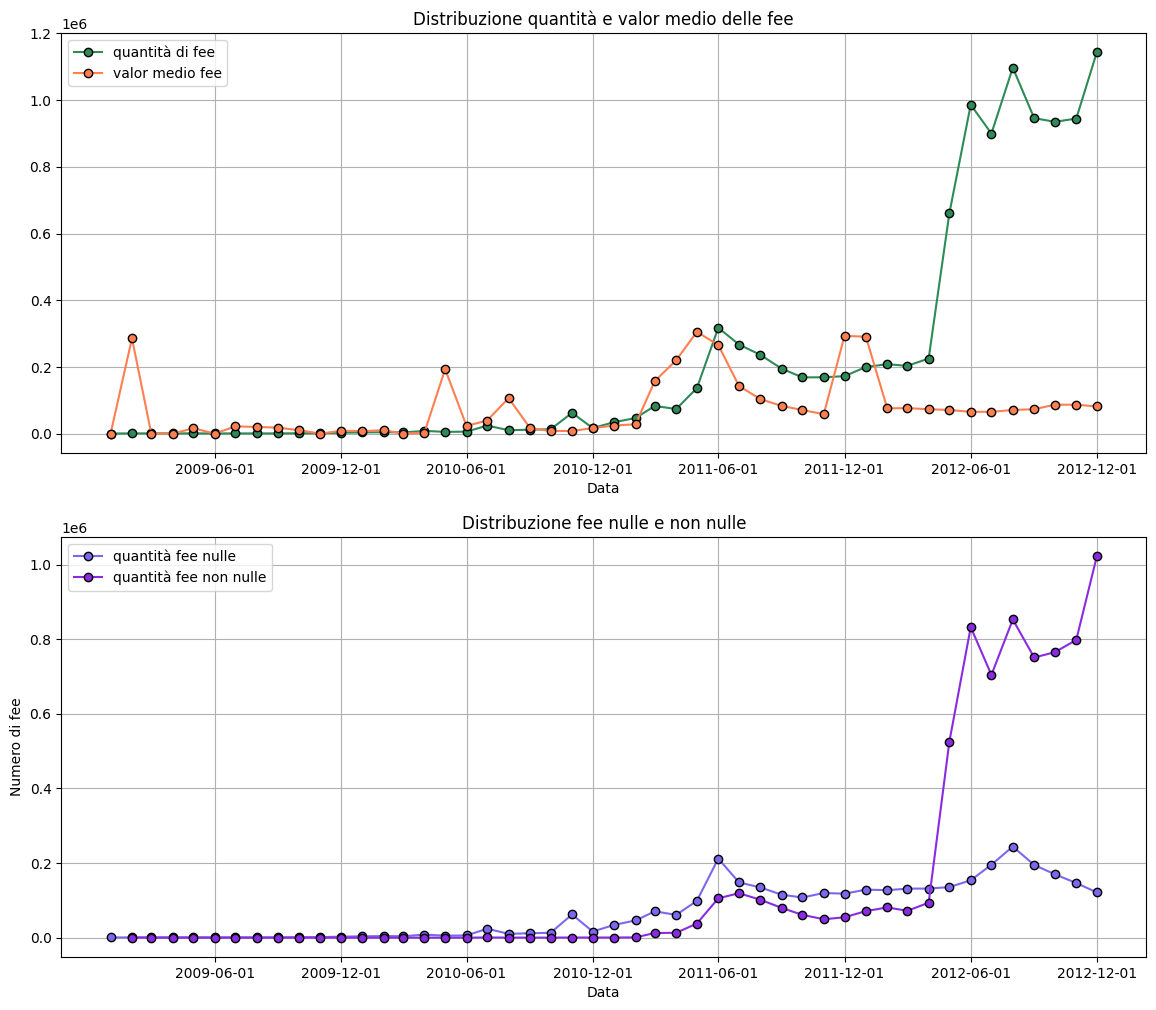

In [14]:
x = fee_per_month.index.to_list()
y1 = fee_per_month.to_list()
y2 = fee_value_per_month.to_list()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

ax1.plot(x, y1, "o-", mec="k", label="quantità di fee", c="seagreen")
ax1.plot(x, y2, "o-", mec="k", label="valor medio fee", c="coral")
ax1.set_title("Distribuzione quantità e valor medio delle fee")
ax1.set_xlabel("Data")
ax1.set_xticks([ts for ts in x if ts.month % 6 == 0])
ax1.grid()
ax1.legend()

x = zero_fee_count.index.to_list()
y = zero_fee_count.tolist()
ax2.plot(x, y, "o-", mec="k", label="quantità fee nulle", c="mediumslateblue")

x = non_zero_fee_count.index.to_list()
y = non_zero_fee_count.tolist()
ax2.plot(x, y, "o-", mec="k", label="quantità fee non nulle", c="blueviolet")

ax2.set_title("Distribuzione fee nulle e non nulle")
ax2.set_xlabel("Data")
ax2.set_ylabel("Numero di fee")
ax2.set_xticks([ts for ts in x if ts.month % 6 == 0])
ax2.grid()
ax2.legend()

plt.show()

## Clusterizzazione degli indirizzi

In questa fase vogliamo implementare l'**euristica multi-input** per la clusterizzazione degli
indirizzi.

L'obbiettivo è quello di riunire in cluster, gli indirizzi appartenenti ad uno stesso utente.

### Grafo degli indirizzi

Per costruire il grafo degli indirizzi dobbiamo:

1. Individuare le transazioni usate come input di ogni transazione.
2. Individuare gli indirizzi di tali transazioni.
3. Per ogni transazione, collegare il primo indirizzo della prima transazione in input con tutti
   gli altri indirizzi delle altre transazioni in input.

Utilizziamo il DataFrame `spent_df` creato in precedenza per il calcolo dell'UTXO poiché mette
sulla stessa riga due transazioni:

- Sulla colonna `tx` troviamo transazioni che riferiscono altre transazioni come loro input.
- Sulla colonna `in_tx` troviamo transazioni riferite come input e di cui conosciamo l'address di
  destinazione.

L'euristica di **clustering** prevede inoltre che si considerino transazioni con più di un input,
sarà necessario filtrare il dataset di conseguenza.


In [15]:
mapping_df = pd.read_csv(
    "mappings.csv",
    names=["hash", "address"],
    dtype={"hash": str, "address": np.uint32},
)

more_than_1 = spent_df.groupby("tx")["utxo_tx"].count().reset_index()
more_than_1 = more_than_1[more_than_1["utxo_tx"] > 1].rename(
    columns={"utxo_tx": "in_count"}
)
more_than_1 = more_than_1.merge(spent_df, how="inner", on="tx").drop(
    columns=["in_count"]
)

more_than_1 = more_than_1.merge(mapping_df, how="inner", on="address")

Ora possiamo popolare il grafo andando a prendere per ogni transazione l'indirizzo del primo input
per collegarlo agli indirizzi degli altri input.

Calcoliamo infine le componenti connesse ottenendo i cluster e ordiniamoli per dimensione.


In [16]:
addr_graph = nx.Graph()

addresses = more_than_1.groupby("tx")["hash"].apply(list)
for a in addresses:
    for i in range(1, len(a)):
        addr_graph.add_edge(a[0], a[i])

clusters = sorted(nx.connected_components(addr_graph), key=len, reverse=True)

### Analisi cluster

Procediamo ora con qualche analisi sui cluster ottenuti come

- Dimensione media, minima e massima dei cluster.
- Distribuzione della dimensione dei cluster.


Numero di cluster trovati: 121464
Dimensione media: 8.4043
Dimensione minima: 1
Dimensione massima: 259773
Dimensione dei 10 cluster più grandi: [259773, 121464, 99645, 76923, 40969, 30916, 26615, 20136, 19894, 16977]


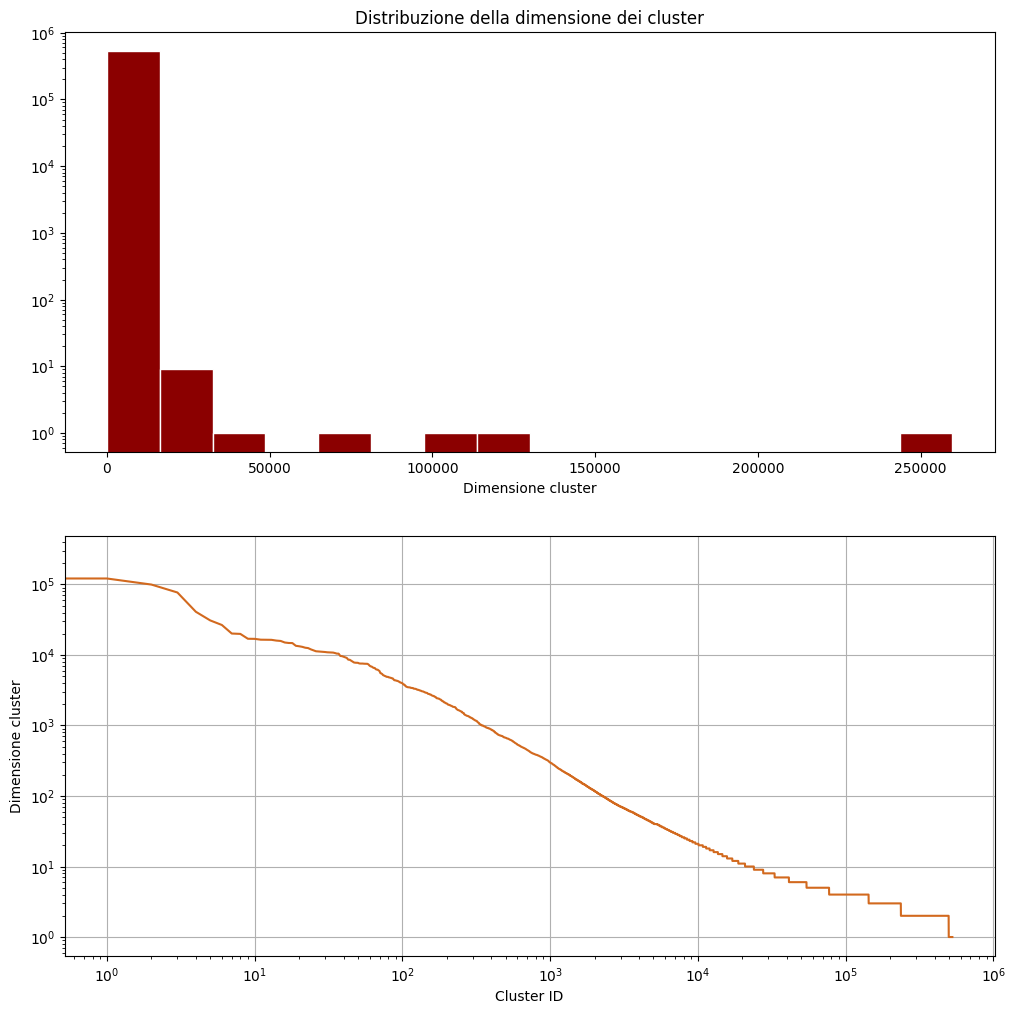

In [17]:
cluster_sizes = [len(cluster) for cluster in clusters]
print(f"Numero di cluster trovati: {len(clusters[1])}")
print(f"Dimensione media: {np.mean(cluster_sizes):.4f}")
print(f"Dimensione minima: {cluster_sizes[-1]}")
print(f"Dimensione massima: {cluster_sizes[0]}")
print(f"Dimensione dei 10 cluster più grandi: {cluster_sizes[:10]}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.hist(cluster_sizes, bins=16, ec="w", color="darkred")
ax1.set_title("Distribuzione della dimensione dei cluster")
ax1.set_xlabel("Dimensione cluster")
ax1.set_yscale("log")

ax2.plot(np.arange(0, len(cluster_sizes)), cluster_sizes, c="chocolate")
ax2.set_xlabel("Cluster ID")
ax2.set_ylabel("Dimensione cluster")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid()

plt.show()

## Deanonimizzazione

Passiamo alla parte di deanonimizzazione degli indirizzi considerando solo i 10 cluster più grandi.

Iniziamo a fare scraping dal sito [WalletExplorer](https://www.walletexplorer.com/).


In [18]:
# base_url = "https://www.walletexplorer.com/"
# session = requests.Session()
# session.headers = {"User-agent": "Mozilla/5.0"}


# def scrape_address(address: tuple) -> None | str:
#     time.sleep(5)
#     r = session.get(base_url, params={"q": address})
#     if r.status_code == 200:
#         soup = bs4.BeautifulSoup(r.text, parser="html.parser")
#         wallet_tag = soup.find("h2")
#         if isinstance(wallet_tag, bs4.Tag):
#             text = wallet_tag.get_text()
#             wallet_name = text.split(" ")[1]
#             if wallet_name.startswith("["):
#                 return None
#             else:
#                 return wallet_name
#     else:
#         return f"Errore {r.status_code}: {r.reason}"


clusters = clusters[:10]
# wallets = []
# too_many_requests = False
# for cluster in clusters:
#     if too_many_requests == True:
#         break
#     for index, addr in enumerate(cluster):
#         if index < 10:
#             wallet_name = scrape_address(addr)
#             if wallet_name != None:
#                 if wallet_name.startswith("Errore"):
#                     print(wallet_name)
#                     too_many_requests = True
#                 else:
#                     wallets.append(wallet_name)
#                 break
#         else:
#             wallets.append("Anonymous wallet")
#             break

# for i, w in enumerate(wallets, start=1):
#     print(f"Cluster {i}: {w}")